# **<font color=white> 09.Regularized Model-LASSO Code 실습**

[목적]
  -  LASSO
    - Regularized Linear Model을 활용하여 Overfitting을 방지함
    - Hyperparameter lamba를 튜닝할 때 for loop 뿐만 아니라 GridsearchCV를 통해 돌출해봄
  -  Regularized Linear Models의 경우 X's Scaling을 필수적으로 진행해야함

[Process]
  -  Define X's & Y
  -  Split Train & Valid dataset
  - Modeling
  -  Model 해석

In [1]:
# Package
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Sklearn Toy Data
from sklearn.datasets import load_diabetes

In [2]:
# Data Loading (당뇨병)
data = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t')

In [3]:
# X's & Y Split
Y = data['Y']
X = data.drop(columns=['Y'])
X = pd.get_dummies(X, columns=['SEX'])

[Data Split]

- Data Split을 진행할 때 BigData의 경우 꼭 indexing을 추출하여 모델에 적용시켜야 함
- 이유는 Data Split하여 새로운 Data set을 만들 경우 메모리에 부담을 주기 때문

In [4]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2023)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))

>>>> # of Train data : 309
>>>> # of valid data : 133


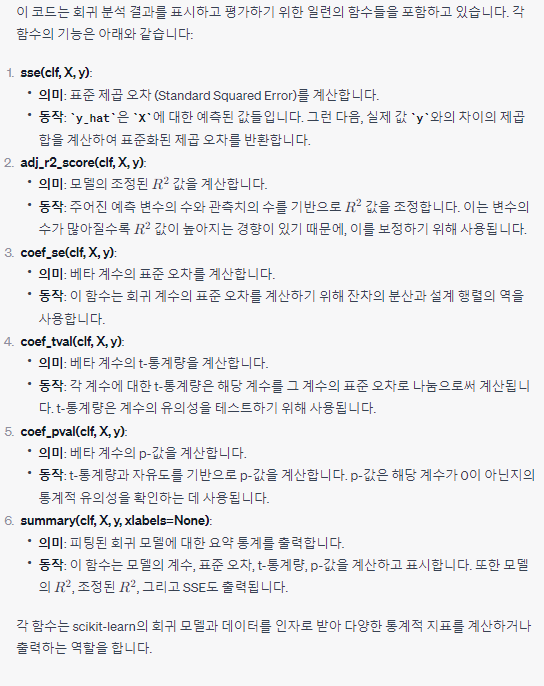

In [10]:
# Scaling
scaler = MinMaxScaler().fit(X.iloc[train_idx])
X_scal = scaler.transform(X)
X_scal = pd.DataFrame(X_scal, columns=X.columns)

In [11]:
import scipy
from sklearn import metrics

def sse(clf, X, y):
    """Calculate the standard squared error of the model.
    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    Returns
    -------
    float
        The standard squared error of the model.
    """
    y_hat = clf.predict(X)
    sse = np.sum((y_hat - y) ** 2)
    return sse / X.shape[0]


def adj_r2_score(clf, X, y):
    """Calculate the adjusted :math:`R^2` of the model.
    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    Returns
    -------
    float
        The adjusted :math:`R^2` of the model.
    """
    n = X.shape[0]  # Number of observations
    p = X.shape[1]  # Number of features
    r_squared = metrics.r2_score(y, clf.predict(X))
    return 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))


def coef_se(clf, X, y):
    """Calculate standard error for beta coefficients.
    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    Returns
    -------
    numpy.ndarray
        An array of standard errors for the beta coefficients.
    """
    n = X.shape[0]
    X1 = np.hstack((np.ones((n, 1)), np.matrix(X)))
    se_matrix = scipy.linalg.sqrtm(
        metrics.mean_squared_error(y, clf.predict(X)) *
        np.linalg.inv(X1.T * X1)
    )
    return np.diagonal(se_matrix)


def coef_tval(clf, X, y):
    """Calculate t-statistic for beta coefficients.
    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    Returns
    -------
    numpy.ndarray
        An array of t-statistic values.
    """
    a = np.array(clf.intercept_ / coef_se(clf, X, y)[0])
    b = np.array(clf.coef_ / coef_se(clf, X, y)[1:])
    return np.append(a, b)


def coef_pval(clf, X, y):
    """Calculate p-values for beta coefficients.
    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    Returns
    -------
    numpy.ndarray
        An array of p-values.
    """
    n = X.shape[0]
    t = coef_tval(clf, X, y)
    p = 2 * (1 - scipy.stats.t.cdf(abs(t), n - 1))
    return p

def summary(clf, X, y, xlabels=None):
    """
    Output summary statistics for a fitted regression model.
    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    xlabels : list, tuple
        The labels for the predictors.
    """
    # Check and/or make xlabels
    ncols = X.shape[1]
    if xlabels is None:
        xlabels = np.array(
            ['x{0}'.format(i) for i in range(1, ncols + 1)], dtype='str')
    elif isinstance(xlabels, (tuple, list)):
        xlabels = np.array(xlabels, dtype='str')
    # Make sure dims of xlabels matches dims of X
    if xlabels.shape[0] != ncols:
        raise AssertionError(
            "Dimension of xlabels {0} does not match "
            "X {1}.".format(xlabels.shape, X.shape))
    # Create data frame of coefficient estimates and associated stats
    coef_df = pd.DataFrame(
        index=['_intercept'] + list(xlabels),
        columns=['Estimate', 'Std. Error', 't value', 'p value']
    )
    try:
        coef_df['Estimate'] = np.concatenate(
            (np.round(np.array([clf.intercept_]), 6), np.round((clf.coef_), 6)))
    except Exception as e:
        coef_df['Estimate'] = np.concatenate(
            (
                np.round(np.array([clf.intercept_]), 6),
                np.round((clf.coef_), 6)
            ), axis = 1
    )[0,:]
    coef_df['Std. Error'] = np.round(coef_se(clf, X, y), 6)
    coef_df['t value'] = np.round(coef_tval(clf, X, y), 4)
    coef_df['p value'] = np.round(coef_pval(clf, X, y), 6)
    # Output results
    print('Coefficients:')
    print(coef_df.to_string(index=True))
    print('---')
    print('R-squared:  {0:.6f},    Adjusted R-squared:  {1:.6f},    MSE: {2:.1f}'.format(
        metrics.r2_score(y, clf.predict(X)), adj_r2_score(clf, X, y), sse(clf, X, y)))

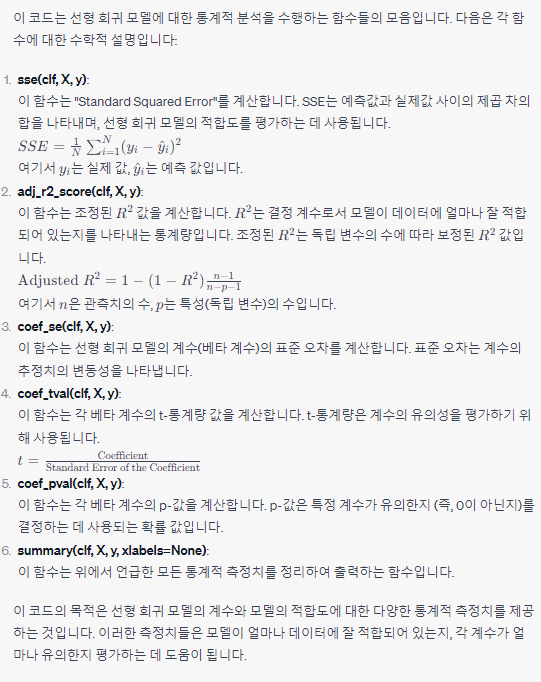

[LASSO Regression]

  - Hyperparameter Tuning using for Loop
  - Hyperparameter Tuning using GridSearchCV

[LASSO Regression Parameters]
  - Package : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
  - alpha : L1-norm Penalty Term
    - alpha : 0 일 때, Just Linear Regression  
  - fit_intercept : Centering to zero
    - 베타0를 0로 보내는 것 (베타0는 상수이기 때문에)
  - max_iter : Maximum number of interation
    - Loss Function의 LASSO Penalty Term은 절대 값이기 때문에 Gradient Descent와 같은 최적화가 필요함
    - Penalty Term : ||y - Xw||^2_2 + alpha * ||w||_1

In [12]:
penelty = [0.0000001, 0.0000005, 0.000001, 0.000005,0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.04]

# LASSO Regression
# select alpha by checking R2, MSE, RMSE
for a in penelty:
    model = Lasso(alpha=a).fit(X_scal.iloc[train_idx], Y.iloc[train_idx])
    score = model.score(X_scal.iloc[valid_idx], Y.iloc[valid_idx])
    pred_y = model.predict(X_scal.iloc[valid_idx])
    mse = mean_squared_error(Y.iloc[valid_idx], pred_y)
    print("Alpha:{0:.7f}, R2:{1:.7f}, MSE:{2:.7f}, RMSE:{3:.7f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0000001, R2:0.5301651, MSE:3084.6122329, RMSE:55.5392855
Alpha:0.0000005, R2:0.5301651, MSE:3084.6121132, RMSE:55.5392844
Alpha:0.0000010, R2:0.5301652, MSE:3084.6119624, RMSE:55.5392831
Alpha:0.0000050, R2:0.5301653, MSE:3084.6107549, RMSE:55.5392722
Alpha:0.0000100, R2:0.5301656, MSE:3084.6092464, RMSE:55.5392586
Alpha:0.0000500, R2:0.5301674, MSE:3084.5972157, RMSE:55.5391503
Alpha:0.0001000, R2:0.5301697, MSE:3084.5822667, RMSE:55.5390157
Alpha:0.0010000, R2:0.5302081, MSE:3084.3301897, RMSE:55.5367463
Alpha:0.0100000, R2:0.5304264, MSE:3082.8971348, RMSE:55.5238429
Alpha:0.0200000, R2:0.5306024, MSE:3081.7414647, RMSE:55.5134350
Alpha:0.0300000, R2:0.5304378, MSE:3082.8220339, RMSE:55.5231666
Alpha:0.0400000, R2:0.5300232, MSE:3085.5438451, RMSE:55.5476718


In [13]:
model_best = Lasso(alpha=0.02).fit(X_scal.iloc[train_idx], Y.iloc[train_idx])
summary(model_best, X_scal.iloc[valid_idx], Y.iloc[valid_idx], xlabels=X.columns)

Coefficients:
              Estimate                  Std. Error         t value   p value
_intercept    4.144976  3.802265e+08+0.000000e+00j  0.0000-0.0000j  1.000000
AGE         -13.359132  2.349221e+01+0.000000e+00j -0.5687+0.0000j  0.570552
BMI         127.876677  3.167722e+01-0.000000e+00j  4.0369+0.0000j  0.000091
BP           66.897382  2.787381e+01-0.000000e+00j  2.4000+0.0000j  0.017790
S1         -153.025383  1.633934e+02-0.000000e+00j -0.9365-0.0000j  0.350703
S2          102.155001  1.150830e+02+0.000000e+00j  0.8877-0.0000j  0.376336
S3          -10.583686  7.271986e+01+0.000000e+00j -0.1455+0.0000j  0.884506
S4            9.263867  5.710492e+01+0.000000e+00j  0.1622-0.0000j  0.871376
S5          181.017864  5.000613e+01-0.000000e+00j  3.6199+0.0000j  0.000419
S6           18.390761  3.387344e+01+0.000000e+00j  0.5429-0.0000j  0.588096
SEX_1        20.777166  3.802265e+08-0.000000e+00j  0.0000+0.0000j  1.000000
SEX_2        -0.000000  3.802265e+08-0.000000e+00j -0.0000-0.0

In [14]:
# Cross Validation for LASSO
lasso_cv=LassoCV(alphas=penelty, cv=5)
model = lasso_cv.fit(X_scal.iloc[train_idx], Y.iloc[train_idx])
print("Best Alpha : {:.7f}".format(model.alpha_))

Best Alpha : 0.0400000


In [15]:
model_best = Lasso(alpha=model.alpha_).fit(X_scal.iloc[train_idx], Y.iloc[train_idx])
score = model_best.score(X_scal.iloc[valid_idx], Y.iloc[valid_idx])
pred_y = model_best.predict(X_scal.iloc[valid_idx])
mse = mean_squared_error(Y.iloc[valid_idx], pred_y)
print("Alpha:{0:.7f}, R2:{1:.7f}, MSE:{2:.7f}, RMSE:{3:.7f}".format(model.alpha_, score, mse, np.sqrt(mse)))
summary(model_best, X_scal.iloc[valid_idx], Y.iloc[valid_idx], xlabels=X.columns)

Alpha:0.0400000, R2:0.5300232, MSE:3085.5438451, RMSE:55.5476718
Coefficients:
              Estimate                  Std. Error         t value   p value
_intercept   21.394535  3.804610e+08+4.014680e+00j  0.0000-0.0000j  1.000000
AGE         -12.257581  2.338128e+01+7.188580e-01j -0.5238+0.0161j  0.601157
BMI         128.605286  3.183205e+01+1.917690e-01j  4.0400-0.0243j  0.000090
BP           66.620187  2.814122e+01+5.408370e-01j  2.3665-0.0455j  0.019390
S1          -76.209202  1.637462e+02+4.365610e-01j -0.4654+0.0012j  0.642406
S2           42.479334  1.152163e+02+2.141600e-01j  0.3687-0.0007j  0.712949
S3          -43.437386  7.276161e+01+3.111610e-01j -0.5970+0.0026j  0.551545
S4            2.391818  5.722290e+01+1.947690e-01j  0.0418-0.0001j  0.966723
S5          154.680886  5.030175e+01+5.204870e-01j  3.0747-0.0318j  0.002560
S6           17.493148  3.409148e+01+6.263920e-01j  0.5130-0.0094j  0.608783
SEX_1        20.663264  3.804610e+08-9.033950e-01j  0.0000+0.0000j  1.0000